In [28]:
# =======================
# 1. Install + imports
# =======================
!pip install -q earthengine-api geemap

import ee
import geemap

# Initialize the API
ee.Initialize(project='pelagic-garage-478911-f9')

In [29]:
# Rectangle around Hartbeespoort Dam (lon_min, lat_min, lon_max, lat_max)
harties_region = ee.Geometry.Rectangle([
    27.80,  -25.79,   # bottom-left (lon, lat)
    27.90,  -25.70    # top-right   (lon, lat)
])

# Make a larger rectangle around the dam (buffer in meters)
harties_region_big = harties_region.buffer(3000).bounds()

print("Region area (km^2):", harties_region.area().getInfo() / 1e6)

# Visualization for a binary water mask, to be used with a clipped NDWI layer
water_mask_dam_vis = {
    'min': 0,
    'max': 1,
    'palette': ['00000000', '0000FF']  # transparent + blue
}

Region area (km^2): 100.23306926436044


In [30]:
# Rectangle around Hartbeespoort Dam (lon_min, lat_min, lon_max, lat_max)
harties_region = ee.Geometry.Rectangle([
    27.80,  -25.79,   # bottom-left (lon, lat)
    27.90,  -25.70    # top-right   (lon, lat)
])

print("Region area (km²):", harties_region.area().getInfo() / 1e6)

# Cloud mask
def maskS2clouds(image):
    qa = image.select('QA60')

    cloudBitMask = 1 << 10   # clouds
    cirrusBitMask = 1 << 11  # cirrus

    mask = (qa.bitwiseAnd(cloudBitMask).eq(0)
              .And(qa.bitwiseAnd(cirrusBitMask).eq(0)))

    return image.updateMask(mask).divide(10000)  # scale reflectance 0–1

# Sentinel-2 SR over Harties for a chosen month
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(harties_region)
              .filterDate('2025-11-01', '2025-11-20')   # 👈 change dates if you like
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .map(maskS2clouds))

print("Number of images in collection:", collection.size().getInfo())


Region area (km²): 100.23306926436044
Number of images in collection: 1


In [35]:
# ==== FULL TILE (NO CLIP) ====
rgb = collection.mean()


hy_thresh = 0.25   # start a bit lower than 0.35

hyacinth_raw = evi.gt(hy_thresh)
hyacinth_raw_dam = hyacinth_raw.updateMask(hyacinth_raw).clip(harties_region)

hy_raw_vis = {
  'min': 0,
  'max': 1,
  'palette': ['00000000', '00FF00']  # transparent -> bright green
}

#  Add debug layer: where EVI > threshold (no water condition yet)


# ---------- NDWI = water ----------
ndwi = rgb.normalizedDifference(['B3', 'B8'])
ndwi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['purple', 'black', 'blue'] 
}

# ---------- NDVI (veg) ----------
ndvi = rgb.normalizedDifference(['B8', 'B4'])
ndvi_vis = {
    'min': 0,
    'max': 0.8,
    'palette': ['brown', 'yellow', 'green']
}

# ---------- EVI (best for hyacinth) ----------
evi = rgb.expression(
    '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
    {
        'NIR': rgb.select('B8'),
        'RED': rgb.select('B4'),
        'BLUE': rgb.select('B2'),
    }
)

evi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['black', 'purple', 'blue', 'green', 'lime']
}

# =====================================================
# === NEW CLEAN HYACINTH MASK (EVI + WATER ONLY) ======
# =====================================================

# 1. Water mask first (NDWI)
water_mask = ndwi.gt(0)     # all water pixels
water_mask_dam = water_mask.updateMask(water_mask).clip(harties_region)

water_mask_vis = {
    'min': 0,
    'max': 1,
    'palette': ['00000000', '00A8FF']   # transparent + blue
}

# 2. Hyacinth = strong EVI
hyacinth_raw = evi.gt(0.35)   

# 3. Hyacinth must lie ON water
hyacinth_on_water = hyacinth_raw.And(water_mask)

# 4. Clip to dam boundary
hyacinth_final = hyacinth_on_water.updateMask(hyacinth_on_water).clip(harties_region)

hyacinth_vis = {
    'min': 0,
    'max': 1,
    'palette': ['00000000', '00FF00']   # transparent + bright green

}



In [36]:
CENTER_LAT = -25.745
CENTER_LON = 27.85

Map = geemap.Map(
    center=[CENTER_LAT, CENTER_LON],
    zoom=13,
    height="600px",
    width="100%",
    scroll_wheel_zoom=False
)

# Base indices
Map.addLayer(hyacinth_raw_dam, hy_raw_vis, 'Hyacinth (EVI only)')
Map.addLayer(rgb,  {'min':0,'max':0.3,'bands':['B4','B3','B2']}, 'RGB Sentinel-2')
Map.addLayer(evi,  evi_vis,  'EVI (full tile)')
Map.addLayer(ndvi, ndvi_vis, 'NDVI (full tile)')
Map.addLayer(ndwi, ndwi_vis, 'NDWI (full tile)')

# New accurate masks:
Map.addLayer(water_mask_dam,    water_mask_vis,    'Dam Water Mask')
Map.addLayer(hyacinth_final,    hyacinth_vis,       'Hyacinth mask (new EVI+NDWI)')

Map.centerObject(harties_region, 13)

# Lock the view around the dam (optional)
Map.max_zoom = 13
Map.min_zoom = 13
Map.dragging = True
Map.touch_zoom = False
Map.double_click_zoom = False

Map

Map(center=[-25.745002854536533, 27.849999999998946], controls=(WidgetControl(options=['position', 'transparen…

In [33]:
import datetime
import os
import geemap

# Reuse your harties_region, collection, maskS2clouds, ndwi, ndvi, evi code.

def get_harties_image_and_mask(start_date, end_date):
    """Return (image, hyacinth_mask) for a given date range."""
    col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(harties_region)
           .filterDate(start_date, end_date)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
           .map(maskS2clouds))

    img = col.mean()

    # Indices
    ndwi = img.normalizedDifference(['B3', 'B8'])
    ndvi = img.normalizedDifference(['B8', 'B4'])
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {
            'NIR': img.select('B8'),
            'RED': img.select('B4'),
            'BLUE': img.select('B2'),
        }
    )

    # Stack 3 channels as input image (EVI / NDVI / NDWI)
    input_image = ee.Image.cat([
        ndwi.rename('ndwi'),
        ndvi.rename('ndvi'),
        evi.rename('evi'),
    ])

    # Hyacinth mask: strong vegetation on water
    water = ndwi.gt(0.1)
    hyacinth_mask = ndvi.gt(0.4).And(evi.gt(0.25)).And(water)
    hyacinth_mask = hyacinth_mask.updateMask(hyacinth_mask).rename('hyacinth')

    # Clip to dam rectangle so you don't get huge tiles
    input_image = input_image.clip(harties_region)
    hyacinth_mask = hyacinth_mask.clip(harties_region)

    return input_image, hyacinth_mask


In [34]:
import pandas as pd
import os
import geemap


os.makedirs("data/images", exist_ok=True)
os.makedirs("data/masks", exist_ok=True)

# Example: take one image per month for 2 years
date_list = pd.date_range("2024-01-20", "2025-11-20", freq="30D")

for start in date_list:
    end = start + pd.Timedelta(days=10)  # 10-day window
    date_str = start.strftime("%Y-%m-%d")
    print("Exporting", date_str)

    img, mask = get_harties_image_and_mask(start.strftime("%Y-%m-%d"),
                                           end.strftime("%Y-%m-%d"))

    # Export image (3 bands: ndwi, ndvi, evi)
    geemap.ee_export_image(
        img,
        filename=f"data/images/{date_str}.tif",
        scale=10,
        region=harties_region,
        file_per_band=False
    )

    # Export mask (single band)
    geemap.ee_export_image(
        mask,
        filename=f"data/masks/{date_str}_mask.tif",
        scale=10,
        region=harties_region,
        file_per_band=False
    )


Exporting 2024-01-20
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/images/2024-01-20.tif
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/masks/2024-01-20_mask.tif
Exporting 2024-02-19
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/images/2024-02-19.tif
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/masks/2024-02-19_mask.tif
Exporting 2024-03-20
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/images/2024-03-20.tif
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/masks/2024-03-20_mask.tif
Exporting 2024-04-19
Generating URL ...
Please wait ...
Data downloaded to /home/user/workspace/Harties_Action_ML_Model/data/images/2024-04-19.tif
Generating URL ...
Ple

KeyboardInterrupt: 

In [ ]:
import os
from glob import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


In [ ]:
!pip install rasterio


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
image_paths = sorted(glob("data/images/*.tif"))
mask_paths  = sorted(glob("data/masks/*_mask.tif"))

len(image_paths), len(mask_paths)


(19, 19)

In [ ]:
import rasterio
import numpy as np

def load_tiff(path):
    with rasterio.open(path) as src:
        arr = src.read()  # shape: (bands, height, width)
    arr = np.transpose(arr, (1, 2, 0))  # convert to (H,W,C)
    return arr


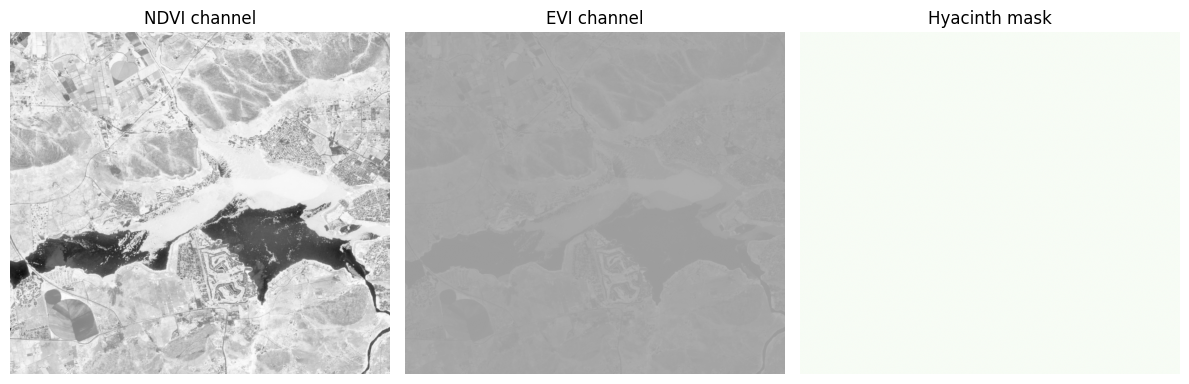

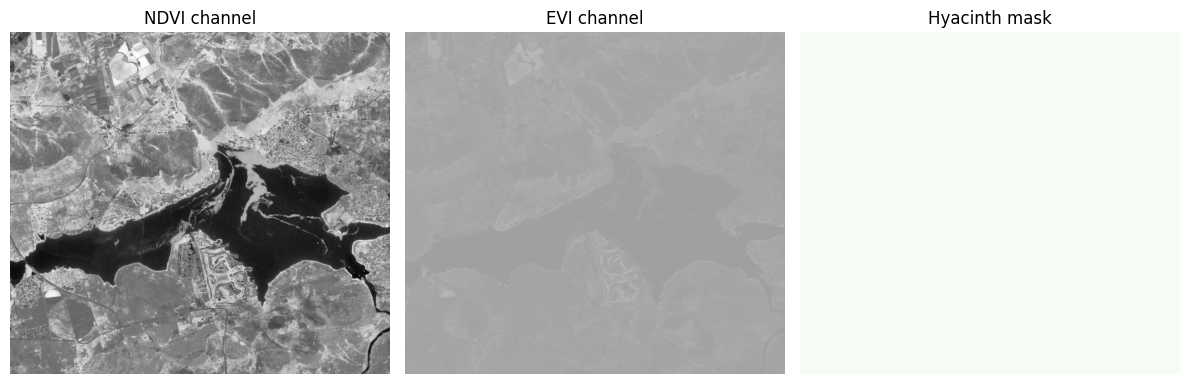

In [ ]:
def show_example(idx):
    img_path  = image_paths[idx]
    mask_path = mask_paths[idx]

    img = load_tiff(img_path)
    mask = load_tiff(mask_path)

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img_arr[:, :, 1], cmap="gray")   # show NDVI channel
    axes[0].set_title("NDVI channel")
    axes[1].imshow(img_arr[:, :, 2], cmap="gray")   # EVI channel
    axes[1].set_title("EVI channel")
    axes[2].imshow(mask_arr, cmap="Greens")
    axes[2].set_title("Hyacinth mask")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_example(0)
show_example(5)


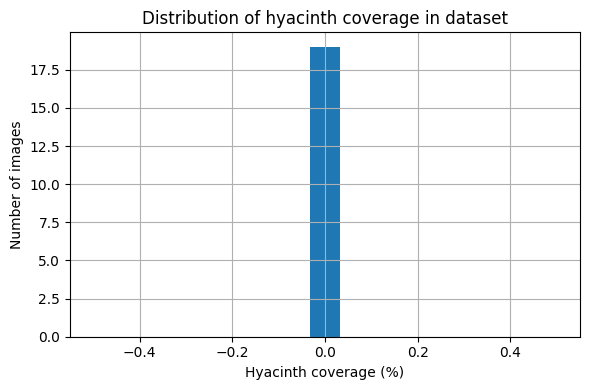

In [ ]:
coverages = []
for mpath in mask_paths:
    mask = np.array(Image.open(mpath))
    coverage = mask.mean() * 100  # since mask is 0/1
    coverages.append(coverage)

plt.figure(figsize=(6,4))
plt.hist(coverages, bins=15)
plt.xlabel("Hyacinth coverage (%)")
plt.ylabel("Number of images")
plt.title("Distribution of hyacinth coverage in dataset")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class HartiesSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # --- Load multi-band GeoTIFF ---
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)  # (C,H,W)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)  # (H,W)

        # --- Normalize image ---
        if img.max() > 1:
            img = img / 10000.0

        # --- Prepare mask ---
        mask = (mask > 0).astype(np.float32)      # 0/1
        mask = np.expand_dims(mask, 0)            # (1,H,W)

        # --- Convert to tensors ---
        img_tensor = torch.from_numpy(img).float()      # (C,H,W)
        mask_tensor = torch.from_numpy(mask).float()    # (1,H,W)

        # resize both to 256x256
        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0),  # (1,C,H,W)
            size=TARGET_SIZE,
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        mask_tensor = F.interpolate(
            mask_tensor.unsqueeze(0),  # (1,1,H,W)
            size=TARGET_SIZE,
            mode="nearest"
        ).squeeze(0)

        return img_tensor, mask_tensor


dataset = HartiesSegmentationDataset(image_paths, mask_paths)

len(dataset)


19

In [ ]:
from glob import glob

image_paths = sorted(glob("data/images/*.tif"))
mask_paths  = sorted(glob("data/masks/*_mask.tif"))

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_ds = HartiesSegmentationDataset(train_imgs, train_masks)
val_ds   = HartiesSegmentationDataset(val_imgs, val_masks)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        # smaller channel sizes
        self.down1 = DoubleConv(in_channels, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(64, 128)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv4 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv1 = DoubleConv(32, 16)

        self.final = nn.Conv2d(16, out_channels, kernel_size=1)

    def center_crop(self, layer, target_h, target_w):
        _, _, h, w = layer.size()
        dh = h - target_h
        dw = w - target_w
        top = dh // 2
        left = dw // 2
        return layer[:, :, top:top+target_h, left:left+target_w]

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)
        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        c4c = self.center_crop(c4, u4.size(2), u4.size(3))
        u4 = torch.cat([u4, c4c], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        c3c = self.center_crop(c3, u3.size(2), u3.size(3))
        u3 = torch.cat([u3, c3c], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        c2c = self.center_crop(c2, u2.size(2), u2.size(3))
        u2 = torch.cat([u2, c2c], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        c1c = self.center_crop(c1, u1.size(2), u1.size(3))
        u1 = torch.cat([u1, c1c], dim=1)
        c1 = self.conv1(u1)

        out = self.final(c1)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)

bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def iou_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > 0.5
    intersection = (pred & target).float().sum((1,2,3))
    union = (pred | target).float().sum((1,2,3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = bce(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            outputs = model(imgs)
            loss = bce(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item() * imgs.size(0)
            val_iou += iou_score(outputs, masks) * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_iou  /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"| Train loss: {train_loss:.4f} "
          f"| Val loss: {val_loss:.4f} "
          f"| Val IoU: {val_iou:.3f}")


NameError: name 'TARGET_SIZE' is not defined

In [ ]:
model.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = torch.sigmoid(model(imgs))

imgs = imgs.cpu().numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

for i in range(min(3, imgs.shape[0])):
    img = imgs[i].transpose(1,2,0)  # CHW->HWC
    mask_true = masks[i,0]
    mask_pred = (preds[i,0] > 0.5).astype(np.float32)

    cov_true = mask_true.mean() * 100
    cov_pred = mask_pred.mean() * 100

    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].imshow(img[:,:,1], cmap="gray")
    axes[0].set_title("Input (NDVI channel)")
    axes[1].imshow(mask_true, cmap="Greens")
    axes[1].set_title(f"True mask\nCoverage: {cov_true:.1f}%")
    axes[2].imshow(mask_pred, cmap="Greens")
    axes[2].set_title(f"Predicted mask\nCoverage: {cov_pred:.1f}%")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
